In [37]:
import pandas as pd
import numpy as np
from matplotlib import colors, cm, text, pyplot as plt
import matplotlib.patches as patches
import sqlite3
from cmcrameri import cm
from os.path import expanduser

In [14]:
from sklearn.cluster import DBSCAN

In [15]:
import peakutils
from scipy import signal
import math
import os

In [16]:
# define a straight line to exclude the charge-1 cloud
def scan_coords_for_single_charge_region(mz_lower, mz_upper):
    scan_for_mz_lower = -1 * ((1.2 * mz_lower) - 1252)
    scan_for_mz_upper = -1 * ((1.2 * mz_upper) - 1252)
    return (scan_for_mz_lower,scan_for_mz_upper)

In [17]:
# determine the maximum filter length for the number of points
def find_filter_length(number_of_points):
    filter_lengths = [51,11,5]  # must be a positive odd number, greater than the polynomial order, and less than the number of points to be filtered
    return filter_lengths[next(x[0] for x in enumerate(filter_lengths) if x[1] < number_of_points)]

In [27]:
EXPERIMENT_NAME = 'P3856'
EXPERIMENT_DIR = '/media/big-ssd/experiments/{}'.format(EXPERIMENT_NAME)
RUN_NAME = 'P3856_YHE211_1_Slot1-1_1_5104'

In [28]:
MZ_MIN = 760
MZ_MAX = 766

In [29]:
charge_one_scan_max = max(scan_coords_for_single_charge_region(mz_lower=MZ_MIN, mz_upper=MZ_MAX))

In [63]:
# constrain the data to re-run the same feature for debugging
MZ_MIN_DEBUG, MZ_MAX_DEBUG = (1037, 1041)
SCAN_MIN_DEBUG, SCAN_MAX_DEBUG = (250, 350)
RT_LOWER_DEBUG, RT_UPPER_DEBUG = (2010, 2020)

In [64]:
PROCESSED_INTENSITY_INDICATOR = -1
INTENSITY_THRESHOLD = 50

In [65]:
# frame types for PASEF mode
FRAME_TYPE_MS1 = 0
FRAME_TYPE_MS2 = 8

In [66]:
# filter and peak detection parameters
VALLEYS_THRESHOLD_RT = 0.5    # only consider valleys that drop more than this proportion of the normalised maximum
VALLEYS_THRESHOLD_SCAN = 0.5

VALLEYS_MIN_DIST_RT = 2.0     # seconds
VALLEYS_MIN_DIST_SCAN = 10.0  # scans

SCAN_FILTER_POLY_ORDER = 3
RT_FILTER_POLY_ORDER = 3

In [67]:
converted_db_name = '{}/converted-databases/exp-{}-run-{}-converted.sqlite'.format(EXPERIMENT_DIR, EXPERIMENT_NAME, RUN_NAME)

In [124]:
db_conn = sqlite3.connect(converted_db_name)
raw_df = pd.read_sql_query("select * from frames where frame_type == {} and mz >= {} and mz <= {} and scan >= {} and scan <= {} and retention_time_secs >= {} and retention_time_secs <= {} and intensity >= {}".format(FRAME_TYPE_MS1, MZ_MIN_DEBUG, MZ_MAX_DEBUG, SCAN_MIN_DEBUG, SCAN_MAX_DEBUG, RT_LOWER_DEBUG, RT_UPPER_DEBUG, INTENSITY_THRESHOLD), db_conn)
db_conn.close()

In [125]:
# assign each point a unique identifier
raw_df['point_id'] = raw_df.index

In [126]:
CUBOIDS_FILE = '{}/precursor-cuboids-debug.pkl'.format(expanduser('~'))
precursor_cuboids_l = []
# remove the cuboids file
if os.path.isfile(CUBOIDS_FILE):
    os.remove(CUBOIDS_FILE)
# a unique id for each precursor cuboid
precursor_cuboid_id = 1

#### repeat from here

In [127]:
# find the most intense point
anchor_point_s = raw_df.loc[raw_df.intensity.idxmax()]
anchor_point_s

frame_id               18082.000000
frame_type                 0.000000
mz                      1040.504700
scan                     281.000000
intensity                166.000000
retention_time_secs     2017.747258
point_id                1431.000000
Name: 1431, dtype: float64

In [72]:
mz_lower = anchor_point_s.mz - 1.0
mz_upper = anchor_point_s.mz + 7.0
scan_lower = anchor_point_s.scan - 100
scan_upper = anchor_point_s.scan + 100

In [73]:
candidate_region_df = raw_df[(raw_df.frame_id == anchor_point_s.frame_id) & (raw_df.mz >= mz_lower) & (raw_df.mz <= mz_upper) & (raw_df.scan >= scan_lower) & (raw_df.scan <= scan_upper)].copy()


In [74]:
MS1_PEAK_DELTA = 0.1

In [75]:
peak_mz_lower = anchor_point_s.mz-MS1_PEAK_DELTA
peak_mz_upper = anchor_point_s.mz+MS1_PEAK_DELTA

In [76]:
minimum_pixel_intensity = 50
maximum_pixel_intensity = 500

In [77]:
# create the colour map to convert intensity to colour
colour_map = cm.batlow_r
norm = colors.LogNorm(vmin=minimum_pixel_intensity, vmax=maximum_pixel_intensity, clip=True)

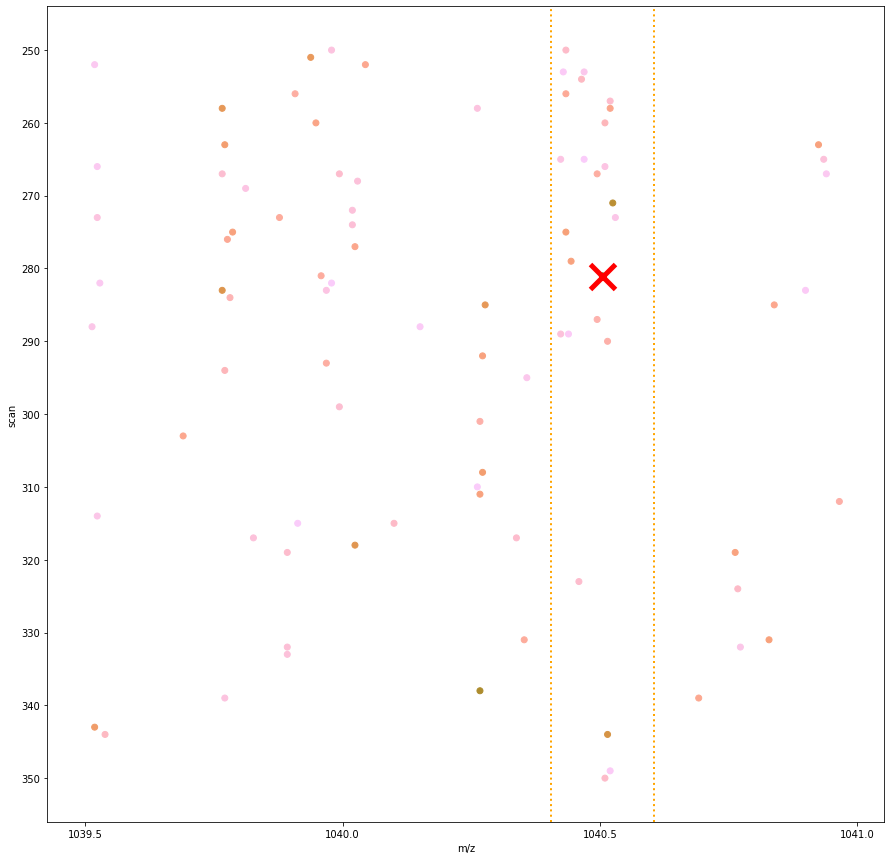

In [78]:
# plot the cluster assignments
f, ax1 = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)

plt.margins(0.06)

plt.scatter(candidate_region_df.mz, candidate_region_df.scan, c=candidate_region_df.intensity, cmap=colour_map, norm=norm)
plt.plot(anchor_point_s.mz, anchor_point_s.scan, marker='x', markerfacecolor='none', markeredgecolor='red', linestyle='', markeredgewidth=5, ms=25, label='anchor point')

plt.axvline(x=peak_mz_lower, linestyle=':', color='orange', linewidth=2)
plt.axvline(x=peak_mz_upper, linestyle=':', color='orange', linewidth=2)

nearest = 0.5
range_l = round(candidate_region_df.mz.min() / nearest) * nearest
range_u = round(candidate_region_df.mz.max() / nearest) * nearest
plt.xticks(np.arange(range_l,range_u+nearest,nearest))

nearest = 10.0
range_l = round(candidate_region_df.scan.min() / nearest) * nearest
range_u = round(candidate_region_df.scan.max() / nearest) * nearest
plt.yticks(np.arange(range_l,range_u+nearest,nearest))

plt.xlabel("m/z")
plt.ylabel("scan")
plt.gca().invert_yaxis()
plt.show()

In [79]:
peak_df = candidate_region_df[(candidate_region_df.mz >= peak_mz_lower) & (candidate_region_df.mz <= peak_mz_upper)]

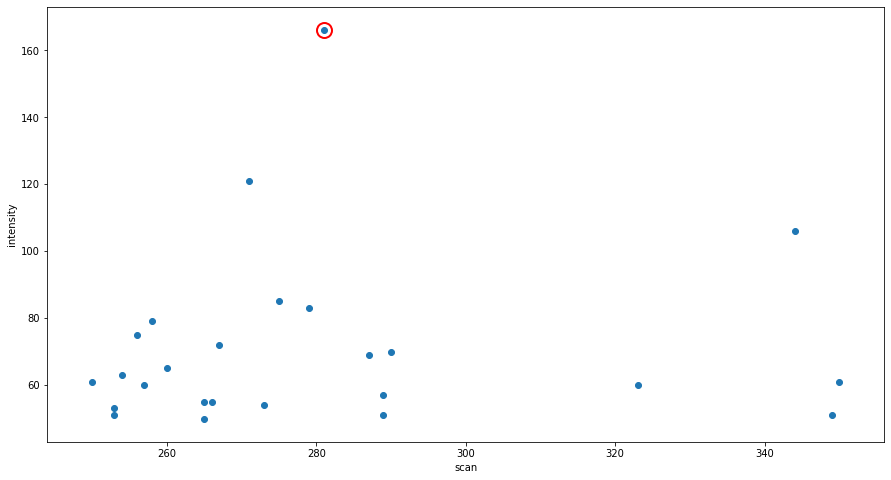

In [80]:
# plot the cluster assignments
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)

plt.scatter(peak_df.scan, peak_df.intensity)
plt.plot(anchor_point_s.scan, anchor_point_s.intensity, marker='o', markerfacecolor='none', markeredgecolor='red', linestyle='', markeredgewidth=2, ms=15, label='anchor point')

plt.xlabel("scan")
plt.ylabel("intensity")
plt.show()

In [81]:
scan_0_df = peak_df.groupby(['scan'], as_index=False).intensity.sum()
scan_0_df.sort_values(by=['scan'], ascending=True, inplace=True)
# filter the points
scan_0_df['filtered_intensity'] = scan_0_df.intensity  # set the default
window_length = 21
if len(scan_0_df) > window_length:
    try:
        scan_0_df['filtered_intensity'] = signal.savgol_filter(scan_0_df.intensity, window_length=find_filter_length(number_of_points=len(scan_0_df)), polyorder=SCAN_FILTER_POLY_ORDER)
        filtered = True
    except:
        filtered = False
else:
    filtered = False

In [82]:
filtered

True

In [83]:
# find the valleys nearest the anchor point
valley_idxs = peakutils.indexes(-scan_0_df.filtered_intensity.values, thres=VALLEYS_THRESHOLD_SCAN, min_dist=VALLEYS_MIN_DIST_SCAN, thres_abs=False)
valley_x_l = scan_0_df.iloc[valley_idxs].scan.to_list()
valleys_df = scan_0_df[scan_0_df.scan.isin(valley_x_l)]

upper_x = valleys_df[valleys_df.scan > anchor_point_s.scan].scan.min()
if math.isnan(upper_x):
    upper_x = scan_0_df.scan.max()
lower_x = valleys_df[valleys_df.scan < anchor_point_s.scan].scan.max()
if math.isnan(lower_x):
    lower_x = scan_0_df.scan.min()

scan_lower = lower_x
scan_upper = upper_x

In [84]:
valleys_df

,scan,intensity,filtered_intensity
5,258,79,70.337995
20,349,51,61.566434


In [85]:
scan_0_extract_df = scan_0_df[(scan_0_df.scan >= lower_x) & (scan_0_df.scan <= upper_x)]

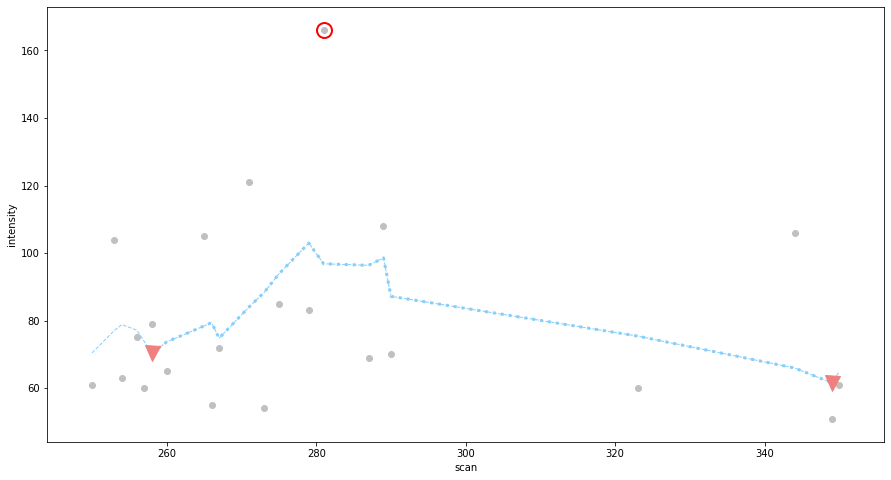

In [86]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)

# plot the flattened points
plt.scatter(scan_0_df.scan, scan_0_df.intensity, c='silver')
# plot the smoothed points
plt.plot(scan_0_df.scan, scan_0_df.filtered_intensity, marker='', color='lightskyblue', linestyle='--', linewidth=1, ms=5, label='smoothed')
plt.plot(scan_0_extract_df.scan, scan_0_extract_df.filtered_intensity, marker='', color='lightskyblue', linestyle=':', linewidth=3, ms=5, label='extracted')

plt.plot(valleys_df.scan, valleys_df.filtered_intensity, marker='v', color='lightcoral', linestyle=None, linewidth=0, ms=15, label='valleys')
plt.plot(anchor_point_s.scan, anchor_point_s.intensity, marker='o', markerfacecolor='none', markeredgecolor='red', linestyle='', markeredgewidth=2, ms=15, label='anchor point')

plt.xlabel("scan")
plt.ylabel("intensity")
plt.show()

#### trim the candidate region to account for the selected peak in mobility

In [87]:
candidate_region_df = candidate_region_df[(candidate_region_df.scan >= lower_x) & (candidate_region_df.scan <= upper_x)]

#### segment the raw data to reveal the isotopes in the feature

In [88]:
X = candidate_region_df[['mz','scan']].values

In [89]:
# a distance metric for points within an isotope
def point_metric(r1, r2):
    mz_1 = r1[0]
    scan_1 = r1[1]
    mz_2 = r2[0]
    scan_2 = r2[1]
    if (abs(mz_1 - mz_2) <= 0.1) and (abs(scan_1 - scan_2) <= 5):
        result = 0.5
    else:
        result = 10
    return result

In [90]:
# cluster the data
dbscan = DBSCAN(eps=1, min_samples=3, metric=point_metric)
clusters = dbscan.fit_predict(X)

In [91]:
candidate_region_df['cluster'] = clusters

In [92]:
candidate_region_df.sample(n=5)

,frame_id,frame_type,mz,scan,intensity,retention_time_secs,point_id,cluster
1484,18082,0,1040.337767,317,60,2017.747258,1484,-1
1438,18082,0,1039.968538,283,55,2017.747258,1438,3
1413,18082,0,1040.019114,272,57,2017.747258,1413,3
1384,18082,0,1040.519877,258,79,2017.747258,1384,0
1397,18082,0,1040.934741,265,57,2017.747258,1397,2


In [93]:
number_of_point_clusters = len(candidate_region_df[candidate_region_df.cluster >= 0].cluster.unique())
print('found {} point clusters'.format(number_of_point_clusters))

found 7 point clusters


In [94]:
colour_map = plt.get_cmap('gist_ncar')
norm = colors.Normalize(vmin=candidate_region_df.cluster.min(), vmax=candidate_region_df.cluster.max(), clip=False)

In [95]:
# collect the points that are in the same point cluster as the anchor point
anchor_point_cluster = candidate_region_df[candidate_region_df.point_id == anchor_point_s.point_id].iloc[0].cluster
anchor_point_cluster_points_df = candidate_region_df[candidate_region_df.cluster == anchor_point_cluster]

In [96]:
# calculate the cluster centroids
centroids_l = []
for group_name,group_df in candidate_region_df.groupby(['cluster'], as_index=False):
    if group_name >= 0:
        mz_centroid = peakutils.centroid(group_df.mz, group_df.intensity)
        scan_centroid = peakutils.centroid(group_df.scan, group_df.intensity)
        centroids_l.append((group_name, mz_centroid, scan_centroid))
centroids_df = pd.DataFrame(centroids_l, columns=['cluster','mz','scan'])

In [97]:
# determine a colour for each cluster
cluster_colour_l = []
for group_name,group_df in candidate_region_df.groupby(['cluster'], as_index=False):
    c = colour_map(norm(group_name), bytes=False)[:3]
    cluster_colour_l.append((group_name, c))
cluster_colour_df = pd.DataFrame(cluster_colour_l, columns=['cluster','colour'])

In [98]:
# give each point a colour
candidate_region_df = pd.merge(candidate_region_df, cluster_colour_df, how='left', left_on=['cluster'], right_on=['cluster'])


In [99]:
candidate_region_df.sample(n=3)

,frame_id,frame_type,mz,scan,intensity,retention_time_secs,point_id,cluster,colour
19,18082,0,1040.019114,272,57,2017.747258,1413,3,"(1.0, 0.8743443122968675, 0.0)"
36,18082,0,1039.781420,284,67,2017.747258,1441,-1,"(0.0, 0.0, 0.502)"
7,18082,0,1040.423761,265,55,2017.747258,1395,0,"(0.0, 0.4981591003460206, 1.0)"


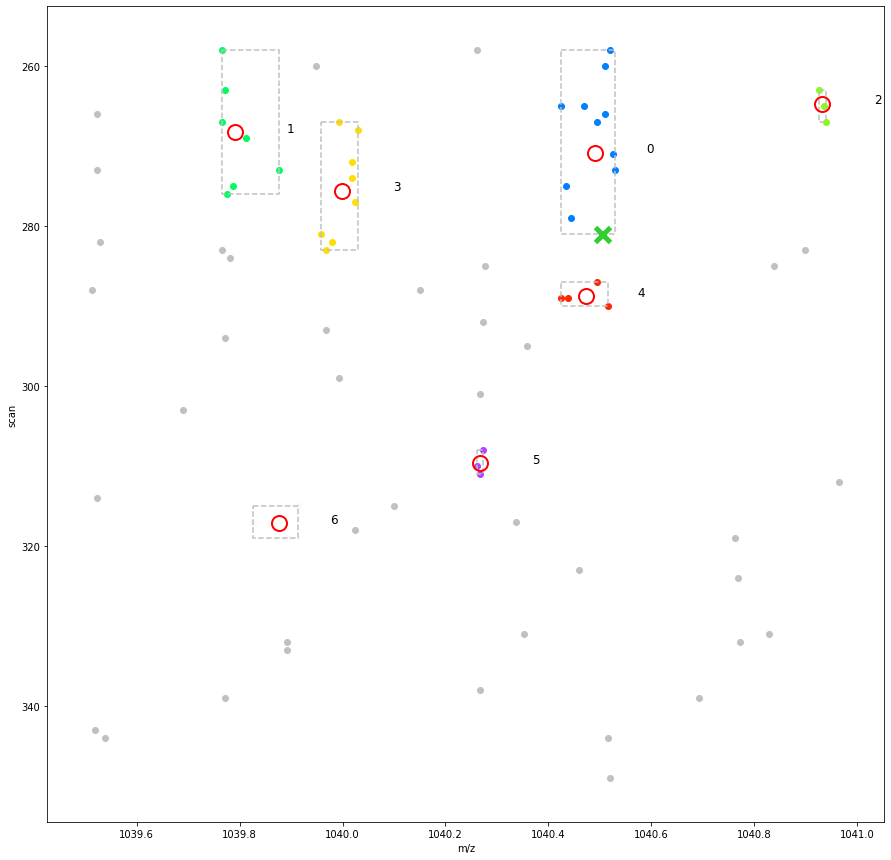

In [100]:
# plot the cluster assignments
f, ax1 = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)

plt.margins(0.06)

# plot the unassigned points
df = candidate_region_df[(candidate_region_df.cluster == -1)]
plt.scatter(df.mz, df.scan, c='silver')

df = candidate_region_df[(candidate_region_df.cluster >= 0)]
for group_name,group_df in df.groupby(['cluster'], as_index=False):
    # the raw points
    plt.scatter(group_df.mz, group_df.scan, c=np.array([group_df.iloc[0].colour]))
    # the cluster centroid
    centroid_s = centroids_df[(centroids_df.cluster == group_name)].iloc[0]
    plt.plot(centroid_s.mz, centroid_s.scan, marker='o', markerfacecolor='none', markeredgecolor='red', linestyle='', markeredgewidth=2, ms=15)
    ax1.text(centroid_s.mz+0.1, centroid_s.scan, group_name, fontsize=12)
    # draw the cluster rectangle
    top_left = (group_df.mz.min(),group_df.scan.min())
    width = group_df.mz.max() - group_df.mz.min()
    height = group_df.scan.max() - group_df.scan.min()
    cluster_rect = patches.Rectangle(top_left,width,height,linewidth=1.5,linestyle='--',edgecolor='silver',facecolor='none')
    ax1.add_patch(cluster_rect)

# the anchor point for this candidate region
plt.plot(anchor_point_s.mz, anchor_point_s.scan, marker='x', markerfacecolor='none', markeredgecolor='limegreen', linestyle='', markeredgewidth=5, ms=15, label='anchor point')

plt.xlabel("m/z")
plt.ylabel("scan")
plt.gca().invert_yaxis()
plt.show()

In [101]:
# a distance metric for isotopes within a series
def isotope_metric(r1, r2):
    mz_1 = r1[0]
    scan_1 = r1[1]
    mz_2 = r2[0]
    scan_2 = r2[1]
    if (abs(mz_1 - mz_2) <= 0.8) and (abs(mz_1 - mz_2) > 0.1) and (abs(scan_1 - scan_2) <= 10):
        result = 0.5
    else:
        result = 10
    # print('r1={}, r2={}, result={}'.format(r1,r2,result))
    return result

In [102]:
X = centroids_df[['mz','scan']].values

In [103]:
# cluster the data
dbscan = DBSCAN(eps=1, min_samples=2, metric=isotope_metric)
clusters = dbscan.fit_predict(X)
centroids_df['isotope_cluster'] = clusters

In [104]:
number_of_isotope_clusters = len(centroids_df[centroids_df.isotope_cluster >= 0].isotope_cluster.unique())
print('found {} isotope clusters'.format(number_of_isotope_clusters))

found 1 isotope clusters


In [105]:
candidate_region_df = pd.merge(candidate_region_df, centroids_df[['cluster','isotope_cluster']], how='left', left_on=['cluster'], right_on=['cluster'])


In [106]:
candidate_region_df.fillna(value=-1, inplace=True)
candidate_region_df.isotope_cluster = candidate_region_df.isotope_cluster.astype(int)

In [107]:
candidate_region_df.sample(n=3)

,frame_id,frame_type,mz,scan,intensity,retention_time_secs,point_id,cluster,colour,isotope_cluster
33,18082,0,1039.766249,283,102,2017.747258,1437,-1,"(0.0, 0.0, 0.502)",-1
15,18082,0,1040.939801,267,52,2017.747258,1406,2,"(0.5182809189613916, 0.9998402909550916, 0.046...",0
3,18082,0,1039.948308,260,80,2017.747258,1387,-1,"(0.0, 0.0, 0.502)",-1


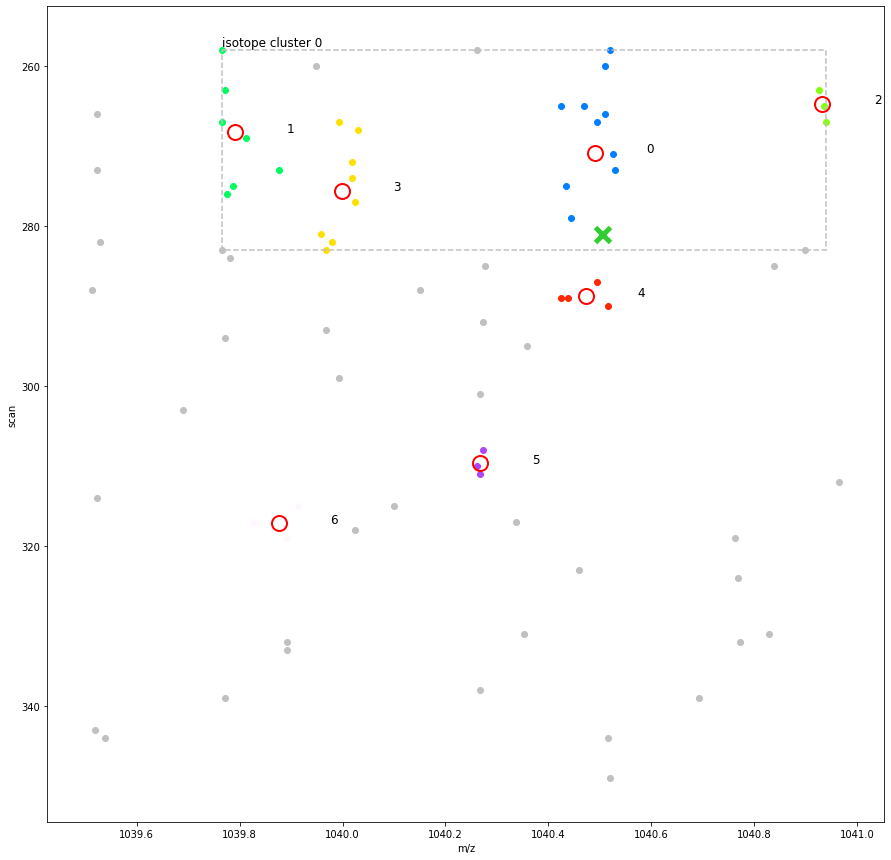

In [108]:
# plot the cluster assignments
f, ax1 = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)

plt.margins(0.06)

# plot the unassigned points
df = candidate_region_df[(candidate_region_df.cluster == -1)]
plt.scatter(df.mz, df.scan, c='silver')

df = candidate_region_df[(candidate_region_df.cluster >= 0)]
for group_name,group_df in df.groupby(['cluster'], as_index=False):
    # the raw points
    plt.scatter(group_df.mz, group_df.scan, c=np.array([group_df.iloc[0].colour]))
    # the cluster centroid
    centroid_s = centroids_df[(centroids_df.cluster == group_name)].iloc[0]
    plt.plot(centroid_s.mz, centroid_s.scan, marker='o', markerfacecolor='none', markeredgecolor='red', linestyle='', markeredgewidth=2, ms=15)
    ax1.text(centroid_s.mz+0.1, centroid_s.scan, group_name, fontsize=12)

df = candidate_region_df[(candidate_region_df.isotope_cluster >= 0)]
for group_name,group_df in df.groupby(['isotope_cluster'], as_index=False):
    # draw the cluster rectangle
    top_left = (group_df.mz.min(),group_df.scan.min())
    width = group_df.mz.max() - group_df.mz.min()
    height = group_df.scan.max() - group_df.scan.min()
    cluster_rect = patches.Rectangle(top_left,width,height,linewidth=1.5,linestyle='--',edgecolor='silver',facecolor='none')
    ax1.add_patch(cluster_rect)
    ax1.text(top_left[0], top_left[1]-0.5, 'isotope cluster {}'.format(int(group_name)), fontsize=12)

# the anchor point for this candidate region
plt.plot(anchor_point_s.mz, anchor_point_s.scan, marker='x', markerfacecolor='none', markeredgecolor='limegreen', linestyle='', markeredgewidth=5, ms=15, label='anchor point')

plot_xlim = ax1.get_xlim()
plot_ylim = ax1.get_ylim()

plt.xlabel("m/z")
plt.ylabel("scan")
plt.gca().invert_yaxis()
plt.show()

#### we now have the 2D extent of the feature - take that extent through time and see if we can cluster the centroids in time

In [109]:
# which cluster contains the anchor point?
anchor_point_s = candidate_region_df[(candidate_region_df.point_id == anchor_point_s.point_id)].iloc[0]


In [110]:
anchor_point_s

frame_id                                        18082
frame_type                                          0
mz                                             1040.5
scan                                              281
intensity                                         166
retention_time_secs                           2017.75
point_id                                         1431
cluster                                             0
colour                 (0.0, 0.4981591003460206, 1.0)
isotope_cluster                                     0
Name: 30, dtype: object

In [111]:
# get the extent of the isotope cluster in m/z and mobility
points_in_cluster_df = candidate_region_df[(candidate_region_df.isotope_cluster == anchor_point_s.isotope_cluster)]
mz_lower = points_in_cluster_df.mz.min()
mz_upper = points_in_cluster_df.mz.max()
scan_lower = points_in_cluster_df.scan.min()
scan_upper = points_in_cluster_df.scan.max()

In [112]:
RT_BASE_PEAK_WIDTH = 10

In [113]:
# get the left-most peak in the isotope cluster
monoisotopic_cluster_s = centroids_df.loc[centroids_df[(centroids_df.isotope_cluster == anchor_point_s.isotope_cluster)].mz.idxmin()]


In [114]:
mono_raw_points_df = raw_df[(raw_df.mz >= anchor_point_cluster_points_df.mz.min()) & (raw_df.mz <= anchor_point_cluster_points_df.mz.max()) & (raw_df.scan >= anchor_point_cluster_points_df.scan.min()) & (raw_df.scan <= anchor_point_cluster_points_df.scan.max()) & (raw_df.retention_time_secs >= anchor_point_s.retention_time_secs-RT_BASE_PEAK_WIDTH) & (raw_df.retention_time_secs <= anchor_point_s.retention_time_secs+RT_BASE_PEAK_WIDTH)]
rt_0_df = mono_raw_points_df.groupby(['frame_id','retention_time_secs'], as_index=False).intensity.sum()
rt_0_df.sort_values(by=['retention_time_secs'], ascending=True, inplace=True)
# filter the points
rt_0_df['filtered_intensity'] = rt_0_df.intensity  # set the default
window_length = 11
if len(rt_0_df) > window_length:
    try:
        rt_0_df['filtered_intensity'] = signal.savgol_filter(rt_0_df.intensity, window_length=find_filter_length(number_of_points=len(rt_0_df)), polyorder=RT_FILTER_POLY_ORDER)
        filtered = True
    except:
        filtered = False
else:
    filtered = False

In [115]:
filtered

True

In [116]:
len(rt_0_df)

15

In [117]:
peak_idxs = peakutils.indexes(rt_0_df.filtered_intensity.values, thres=0.05, min_dist=10/2, thres_abs=False)
peak_x_l = rt_0_df.iloc[peak_idxs].retention_time_secs.to_list()
peaks_df = rt_0_df[rt_0_df.retention_time_secs.isin(peak_x_l)]

In [118]:
valley_idxs = peakutils.indexes(-rt_0_df.filtered_intensity.values, thres=0.05, min_dist=10/8, thres_abs=False)
valley_x_l = rt_0_df.iloc[valley_idxs].retention_time_secs.to_list()
valleys_df = rt_0_df[rt_0_df.retention_time_secs.isin(valley_x_l)]

In [119]:
valleys_df

,frame_id,retention_time_secs,intensity,filtered_intensity
5,18047,2014.043101,60,186.624709


In [120]:
upper_x = valleys_df[valleys_df.retention_time_secs > anchor_point_s.retention_time_secs].retention_time_secs.min()
if math.isnan(upper_x):
    upper_x = rt_0_df.retention_time_secs.max()
lower_x = valleys_df[valleys_df.retention_time_secs < anchor_point_s.retention_time_secs].retention_time_secs.max()
if math.isnan(lower_x):
    lower_x = rt_0_df.retention_time_secs.min()

In [121]:
rt_lower = lower_x
rt_upper = upper_x

In [122]:
rt_0_extract_df = rt_0_df[(rt_0_df.retention_time_secs >= lower_x) & (rt_0_df.retention_time_secs <= upper_x)]

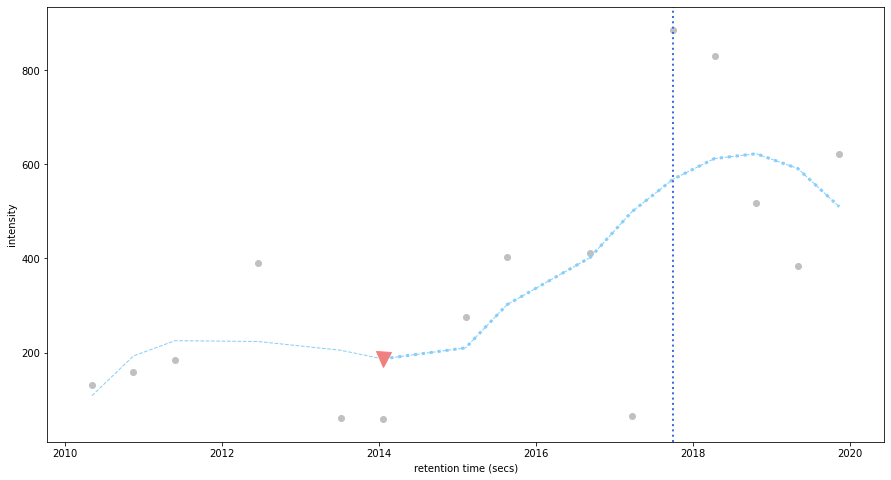

In [123]:
# plot the cluster assignments
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)

# plot the flattened points
plt.scatter(rt_0_df.retention_time_secs, rt_0_df.intensity, c='silver')
# plot the smoothed points
plt.plot(rt_0_df.retention_time_secs, rt_0_df.filtered_intensity, marker='', color='lightskyblue', linestyle='--', linewidth=1, ms=5, label='smoothed')
plt.plot(rt_0_extract_df.retention_time_secs, rt_0_extract_df.filtered_intensity, marker='', color='lightskyblue', linestyle=':', linewidth=3, ms=5, label='extracted')

plt.plot(valleys_df.retention_time_secs, valleys_df.filtered_intensity, marker='v', color='lightcoral', linestyle=None, linewidth=0, ms=15, label='valleys')
plt.axvline(x=anchor_point_s.retention_time_secs, linestyle=':', color='royalblue', linewidth=2, label='anchor point')

plt.xlabel("retention time (secs)")
plt.ylabel("intensity")
plt.show()